This is based on one of the projects defined by Andrew Ng and the online course Macine Learning at coursera! That Project has been done in Octave! And I would like to do it with python (Jupyter) to learn more about python and NN. It is written for python 3.

There are still a lot of improvement possible like:
0. provid numerical partial derivation calculation to check whether the Back Propagation is working fine
0. ploting the cost function in terms of iterations
0. using advanced optimization algorithm which can choose the learning rate automatically for faster convergence
0. checking the learning curves
0. changing the ragularization
0. dividing data to three parts such as training set, cross validation set and test set and compare them.

In [1]:
# required libraries
import scipy
import scipy.io as sio           # to import .mat file, data of images
import numpy as np
import random                    # to create random matrices for weights of NN as initilisation
import matplotlib
import matplotlib.pyplot as plt  # to plot the images

Importing the data from the .mat file

In [2]:
# import .mat file (octave or matlab file) and show some of them and their size
training_data = sio.loadmat('ex4data1.mat')
print(type(training_data))
# print(training_data)
X = training_data['X']
y = training_data['y']
print('\n','input (of training data) of the neural netwok')
print(X)
print('size =',np.shape(X))
print('\n','output (of training data) of the neural netwok')
print(y)
print('size =',np.shape(y))

<class 'dict'>

 input (of training data) of the neural netwok
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
size = (5000, 400)

 output (of training data) of the neural netwok
[[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]]
size = (5000, 1)


Showing random image

image 1544 is number [3]


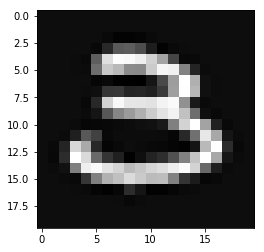

In [3]:
# show an image
# random.seed(1)
index = random.randint(0,np.shape(X)[0]) # 0 to 4999 indices
print('image' ,index, 'is number', y[index])
img = X[index][:]

# the data of an image stored in a row and should be reshaped to be shown!
# we know that all images are 20 * 20 pixels in size
img = img.reshape((20,20)) 
img = img.T
# print(img)
plt.imshow(img, cmap='gray')
plt.show()

Some description about the below code:

theta s are the weight matrices for the input layer and hidden layer.

Theta1_grad and Theta2_grad are partial derivatives of cost function with respect to theta s.

Line 50 - 57:
The data is saved in X and y. X includes images and y includes labels for those images. So raw y is a 5000 by 1 matrix. I wanted to transfer it to a 10 by 5000 matrix. Because if the image is showing number 3, the output should look like this [[0], [0], [1], [0], [0], [0], [0], [0], [0], [0]] as a column-wise vector. Now I need 1 column like this for each image. Then it would be 10 by 5000 as y_vect. So I used y_vect on the rest of the code 

In [4]:
# given by Siraj: https://github.com/yosoufe/Make_a_neural_network/blob/master/demo.py
# and modified by me! the modification is to make the neural network bigger to :
# 1 input layer
# 1 hidden layer
# 1 output layer (with 10 classes, one for each number)


from numpy import exp, array, random, dot

class NeuralNetwork():
    # initilising the random matrices based on dimentsion, mean = zero and range (-0.12,0.12)
    def __rand_init_weights(self,L_out, L_in):
        init_epsilon = 0.12;
        return np.random.random((L_out,L_in)) * (2 * init_epsilon) - init_epsilon;
    
    # initilise the object with number of neurons at each layer
    # if you have some initial weights, you can feed them into the object (as np.ndarray).
    # otherwise feed zero as init_theta1,init_theta2
    def __init__(self,N_input,N_hidden,N_output,init_theta1,init_theta2):
        self.n_input = N_input # #neurons at input level
        self.n_hidden = N_hidden # #neurons at hidden level
        self.n_output = N_output # #neurons at output level
        # this was quite importnant! without good initialisation you will get stuck in local minimum and 
        # you won't get a cost function better than 3.4
        if (isinstance(init_theta1,np.ndarray) and isinstance(init_theta2,np.ndarray)):
            if (init_theta1.shape == (N_hidden,N_input+1) and init_theta2.shape == (N_output,N_hidden+1)): # if there is initial value for thetas
                self.theta1 = init_theta1
                self.theta2 = init_theta2
                print('initial weights are consistent with the layers neuron numbers :)' )
        else: # if there is no initial theta value for thetas
            self.theta1 = self.__rand_init_weights(N_hidden,N_input+1) # initilise weights for first layer (with bias)
            self.theta2 = self.__rand_init_weights(N_output,N_hidden+1) # initilise weights for 2nd layer (with bias)

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def __sigmoid(self, x):
        return scipy.special.expit(x) # can handles exp when is going to be too big (avoid exp overflow)

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def __sigmoid_derivative(self, x):
        x = self.__sigmoid(x)
        return (x * (1.0 - x))

    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations,alpha,lamb):
        X = training_set_inputs
        y = training_set_outputs
        m = X.shape[0]; # number of samples
        n = X.shape[1]; # number of features
        print (m , 'samples with' , n , 'features each')
        y_vect = np.zeros((self.n_output,m))
        for index in range(m):
            y_vect [y[index]-1,index] = 1
        
        X1 = np.concatenate( (np.ones(( m , 1 )) , training_set_inputs ) , 1)
        for iteration in range(number_of_training_iterations):
            z2 = dot( self.theta1 , X1.T )
            a2 = self.__sigmoid(z2)
            a2_1 = np.concatenate( (np.ones(( 1 ,a2.shape[1]   )) , a2 ) , 0)
            z3 = dot( self.theta2 ,  a2_1)
            a3 = self.__sigmoid(z3)  # output of NN

            # Cost Function
            J = -y_vect * np.log(a3) - (1 - y_vect) * np.log( 1 - a3)
            J = J.sum()/m
            J = J + lamb/m/2 * (self.theta1.sum() + self.theta2.sum()) # regularization terms
            print('\r','Cost function at iteration',iteration+1,'of',number_of_training_iterations, 'is' ,J, 'with alpha =',alpha, '& lambda =' , lamb, end='')

            # Back Propagation
            Delta1 = np.zeros(self.theta1.shape)
            Delta2 = np.zeros(self.theta2.shape)
            index = 1
            for index in range(m):
                delta3 = a3[:,index]-y_vect[:,index]
                delta2 = dot( self.theta2.T , delta3[:,None])[1:] * self.__sigmoid_derivative(z2[:,index])[:,None]
                Delta1 = Delta1 + dot(delta2 , X1[index,:][None,:])
                Delta2 = Delta2 + dot(delta3[:,None] , a2_1[:,index][None,:] )

            Theta1_grad = Delta1 / m
            Theta2_grad = Delta2 / m
            
            # regularized BP
            Theta1_grad = Theta1_grad + np.concatenate((np.zeros((self.n_hidden,1)), self.theta1[:,1:]*(lamb/m)),1);
            Theta2_grad = Theta2_grad + np.concatenate((np.zeros((self.n_output,1)), self.theta2[:,1:]*(lamb/m)),1);
            
            adjust_theta1 = Theta1_grad * alpha
            adjust_theta2 = Theta2_grad * alpha
            
            self.theta1 -= adjust_theta1
            self.theta2 -= adjust_theta2

            
    # The neural network thinks.
    def think(self, inputs):
    # Pass inputs through our neural network (our single neuron).
        if len(inputs.shape)==1: # only one example
            inputs1 = np.concatenate( (np.array([1]) , inputs ) , 0)
            inputs1 = inputs1[None,:]
            print(inputs1.shape)
        else: #more than one example
            m = inputs.shape[0]
            inputs1 = np.concatenate( (np.ones(( m , 1 )) , inputs ) , 1)
        
        z2 = dot( self.theta1 , inputs1.T )
        a2 = self.__sigmoid(z2)
        a2_1 = np.concatenate( (np.ones(( 1 ,a2.shape[1]   )) , a2 ) , 0)
        z3 = dot( self.theta2 ,  a2_1)
        a3 = self.__sigmoid(z3)  # output of NN
        return a3.argmax(0)+1

In [5]:
# generate an object from neural network class
# why 25 hidden neurons? I really do not know! It seems it is comming from experiments
# 400 neurons as input bacause images are 20 by 20 in pixels and in total 400 pixels
# 10 neurons for output layer because there are 10 different class as output, each for one number [1 to 10]
neural_network = NeuralNetwork(400,25,10,0,0) # run this for first time

# you can run this with a given theta
# neural_network = NeuralNetwork(400,25,10,neural_network.theta1,neural_network.theta2) 

In [6]:
# train the network
neural_network.train(X,y,1000,0.9,0)

5000 samples with 400 features each
 Cost function at iteration 1000 of 1000 is 0.351259613409 with alpha = 0.9 & lambda = 0

(1, 401)
Predicted output = [6] and actual output is = [6]


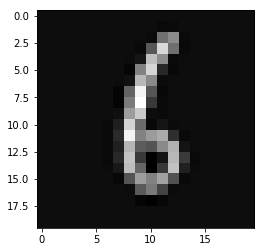

In [7]:
# check how well it works. You can implement a function to check for all images and calculate the precision!
# In octave, the same algorithm reached more than 90% but with using some advenced optimisation algorithms
ind = 3260 # change the index to see other images
print('Predicted output =' ,neural_network.think(X[ind,:]), 'and actual output is =', y[ind])
img = X[ind][:]

# the data of an image stored in a row and should be reshaped to be shown!
# we know that all images are 20 * 20 pixels in size
img = img.reshape((20,20)) 
img = img.T
plt.imshow(img, cmap='gray')
plt.show()

## Making a video

In [8]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import matplotlib.pyplot as plt
import cv2
import pylab as pyl

In [9]:
def create_labeled_img (img , label):
    img = img.reshape((20,20))
    img = img.T
    img_labeled = np.zeros((20,40))
    img_labeled[:,0:20]=img
    img_labeled[:,20:40]=1
    large_img = cv2.resize(img_labeled, (0,0), fx=20, fy=20) 
    cv2.putText(large_img, 'Predicted Value', (500,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 0 , 2 ,cv2.LINE_AA)
    cv2.putText(large_img, str(label), (500,300), cv2.FONT_HERSHEY_SIMPLEX, 6, 0 , 10 ,cv2.LINE_AA)
    plt.imshow(large_img,cmap='gray')
#     plt.show()
    return large_img

for idx in range(50):
    ind = random.randint(0, 4999)
    if y[ind] == 10 :
        out = create_labeled_img(X[ind,:],int(0))
    else :
        out = create_labeled_img(X[ind,:],int(y[ind]))
    plt.imsave('images/sample-out%02d.png'%idx,out,cmap='gray')

to create a movie in ubuntu you can use also this command after the above code or simply run the following section.
```
ffmpeg -f image2 -r 1 -i sample-out%2d.png -vcodec mpeg4 -y movie.mp4
```

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML, Image

fig = plt.figure()
fig.patch.set_visible(False)
plt.axis('off')
fig.tight_layout();

def create_labeled_img (img , label):
    img = img.reshape((20,20))
    img = img.T
    img_labeled = np.zeros((20,40))
    img_labeled[:,0:20]=img
    img_labeled[:,20:40]=255
    large_img = cv2.resize(img_labeled, (0,0), fx=20, fy=20) 
    cv2.putText(large_img, 'Predicted Value', (500,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 0 , 2 ,cv2.LINE_AA)
    cv2.putText(large_img, str(label), (500,300), cv2.FONT_HERSHEY_SIMPLEX, 6, 0 , 10 ,cv2.LINE_AA)
    imgplot = plt.imshow(large_img,cmap='gray', vmin=0, vmax=255)#, vmin=0, vmax=255
    imgplot.set_array(large_img)
#     plt.show()
    return imgplot

def update():
    ind = random.randint(0, 4999)
    if y[ind] == 10 :
        out = create_labeled_img(X[ind,:]*255,int(0))
    else:
        out = create_labeled_img(X[ind,:]*255,int(y[ind]))
#     plt.imsave('images/sample-out%02d.png'%idx,out,cmap='gray')
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    return out

myimages = []
for k in range(1,30):
    imgplot = update()
    myimages.append([imgplot])

myanim = animation.ArtistAnimation(fig, myimages, interval=1000,blit=True)
myanim.save("anim.mp4", fps=1)
myanim.save("anim.gif", fps=1, writer='imagemagick')
# Image(url='anim.gif')
HTML(myanim.to_html5_video())